## 0. Structuring your Agents' and Environments' classes

In this tutorial, we'll learn how to implement reinforcement learning (RL) agents and environments following the structure of the OpenAI Gym (now Gymnasium by Farama Foundation) API. This standardized approach will help you organize your code and make it easier to extend to more complex environments later. Take a look at the figure below to refresh your memories on how Agents interact with Environments:

<div>
<img src="assets/the-general-framework-of-reinforcement-learning.webp" width="500">
</div>

### 0.1. Environment Structure

Let's start by looking at the basic structure of an environment. You should always aim to follow the [Gym API](https://github.com/Farama-Foundation/Gymnasium?tab=readme-ov-file#api) for any new tasks you define for your projects. Here's what it looks like:

```python
class Environment:
    def step(self, action) -> tuple:
        # Implement the dynamics of the environment
        # Returns: next_state, reward, terminated, truncated, info
        pass

    def reset(self) -> tuple:
        # Reset the environment to its initial state
        # Returns: initial_state, info
        pass
```

The `step` method is crucial. It takes an action as input and returns four values:

- `next_state`: The state of the environment after taking the action
- `reward`: The reward received for taking the action
- `terminated`: A boolean indicating whether the agent has reached the terminal state
- `truncated`: A boolean indicating whether the episode is truncated, e.g. prematurely ended
- `info`: A dictionary containing additional information (optional)

The `reset` method initializes a new episode and returns the initial state.

### 0.2. Agent Structure
Now, let's look at the basic structure of an agent:


```python
class Agent:
    def __init__(self, action_space, state_space):
        self.action_space = action_space
        self.state_space = state_space

    def act(self, state):
        # Implement the agent's policy
        # Returns: chosen action
        pass

    def update(self, state, action, reward, next_state, next_action=None):
        # Update the agent's internal parameters
        pass
```

The `act` method implements the agent's policy, deciding which action to take given the current state. The `update` method is used to update the agent's internal parameters based on its experience. As opposed to the `Environment` class where you should follow the `step` and `reset` naming conventions, you can freely choose what you like for the `Agent`. In this course, however, we will follow the convention defined above.

### 0.3. Training Function

To tie everything together, we'll use a training function. This function will run episodes, allowing the agent to interact with the environment and learn from its experiences.

```python
def train_agent(agent: Agent, env: Environment, num_episodes: int = 100):
    # initialize list to collect data (here: only rewards)
    reward_history = []

    for episode in range(num_episodes):
        # fetch state from the environment
        state, _ = env.reset()
        
        # initialize episode's reward and termination conditions
        total_reward = 0
        done = False

        while not done:
            # agent acts acc. to its policy given environment's state
            action = agent.act(state)

            # environment returns next state, reward, and other info
            next_state, reward, done, _, info = env.step(action)

            # agent uses this info to learn
            agent.update(state, action, reward, next_state)

            # update state and reward
            state = next_state
            total_reward += reward
        
        # when episode ends, record the total reward obtained
        reward_history.append(total_reward)

    return reward_history
```

This function does the following:
- Runs for a specified number of episodes
- For each episode:
  - Resets the environment
  - Lets the agent choose actions and interact with the environment
  - Updates the agent based on the observed transitions
  - Keeps track of the total reward for the episode
- Returns a history of rewards for each episode

In [1]:
# 

## 1. Implement specific agents

In this tutorial, we'll implement three types of agents:
- Random Agent: Takes random actions
- SARSA Agent: Uses the SARSA (State-Action-Reward-State-Action) algorithm
- Q-Learning Agent: Uses the Q-learning algorithm

In [41]:
# QLearning Agent
import numpy as np

class QLearningAgent:
    def __init__(self, action_space, state_space):
        self.action_space = action_space
        self.state_space = state_space
        self.q_table = np.zeros(state_space + (action_space.n,))
        self.gamma = 0.99
        self.alpha = 0.1
        self.epsilon = 1
        self.epsilon_decay = self.epsilon / 4_000
        self.rng = np.random.default_rng()

    def act(self, state):
        if self.rng.random() > self.epsilon:
            action = np.argmax(self.q_table[state])
            # print(f"Exploiting: state {state}, action {action}, Q-value {self.q_table[state][action]}")
        else:
            action = self.rng.integers(0, self.action_space.n)
            # print(f"Exploring: state {state}, action {action}")
        return action

    def update(self, state, action, reward, next_state, done):
        max_future_q = np.max(self.q_table[next_state])
        current_q = self.q_table[state][action]
        if done:
            new_q = reward
        else:
            new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
        self.q_table[state][action] = new_q

        # print(f"Update: state {state}, action {action}, reward {reward}, next_state {next_state}")
        # print(f"Q-value changed from {current_q} to {new_q}")

        if self.epsilon - self.epsilon_decay > 0:
            self.epsilon -= self.epsilon_decay
        
        # print(f"New epsilon: {self.epsilon}")

## 2. Q-Learning in Gym

In this section, we will see the power of Q-Learning in slightly more complex environments. 

### 2.1. The Frozen Lake problem

(A simple gridworld which is Gymnasium's "FrozenLake-v1". Yet to be implemented.)

### 2.2. The Cartpole problem

The [CartPole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) consists of a pole attached by an un-actuated joint to a cart, which moves along a frictionless one-dimensional track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

![CartPole](assets/cart_pole.gif)

> NOTE:
> To use it with our agent, we need to discretize the state because it is continuous. Don't worry, you don't have to implement that. It's already present in `environments.py`. Feel free to take a look or ignore it.

In [42]:
from environments import CartPoleEnvironment

# Create the environment and agent
env = CartPoleEnvironment()
agent = QLearningAgent(env.env.action_space, env.observation_shape)

In [45]:
# define train_agent function

def train_agent(agent, env, num_episodes=6_000):
    reward_history = []
    early_stop_threshold = 195
    early_stop_consecutive = 100
    consecutive_solves = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        reward_history.append(total_reward)
        print(f"Episode {episode} reward: {total_reward}", end="\r")

        if total_reward >= early_stop_threshold:
            consecutive_solves += 1
            if consecutive_solves >= early_stop_consecutive:
                print(f"\nEnvironment solved in {episode+1} episodes!")
                break
        else:
            consecutive_solves = 0

    print("\nTraining completed")
    return reward_history

Episode 5999 reward: 35.00
Training completed


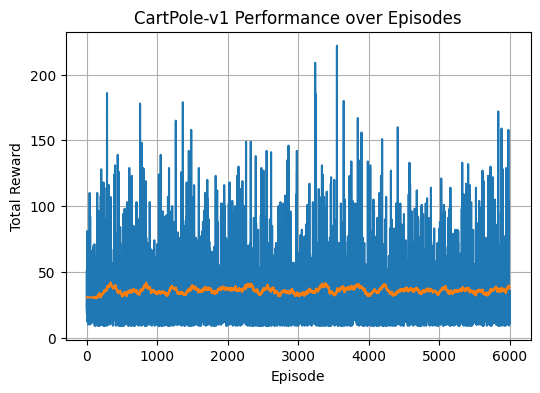

In [46]:
import matplotlib.pyplot as plt

# Train the agent
reward_history = train_agent(agent, env)

# define helper function for plotting
def calculate_moving_average(reward_history, window_size=100):
    cumsum = np.cumsum(np.insert(reward_history, 0, 0))
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    # Use the first calculated average for all previous elements
    first_avg = moving_avg[0]
    padded_avg = np.full(window_size - 1, first_avg)

    return np.concatenate([padded_avg, moving_avg])


def plot_performance(reward_history):
    plt.figure(figsize=(6, 4))
    plt.plot(reward_history)
    plt.plot(calculate_moving_average(reward_history))
    plt.title('CartPole-v1 Performance over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

plot_performance(reward_history)

In [40]:
agent.q_table.shape

(20, 20, 20, 20, 2)